# Transmission spectroscopy model example I

*Author:* Hannu Parviainen<br>
*Last modified:* 2. February 2024

The *Transmission spectroscopy* transit model implemented by ``pytransit.TSModel`` is a specialised version of the Road Runner model (RRModel, Parviainen, 2020) tailored for fast transmission spectroscopy. Like the RRModel, it allows for any radially symmetric function to be used to model stellar limb darkening, but has some optimisations for transmission spectroscopy.

Because of these optimisations, **`TSModel` doesn't support all the the features in the standard PyTransit API**. The main differencet are:

- The planet-star radius ratios (`k`) need to be given as a 1D array (or list) with a shape `(npb)` or a 2D array with a shape `(npv, npb)`, where `npv` is the number of simultaneously evaluated parameter sets and `npb` the number of passbands.
- The model doesn't support heterogeneous data sets so the light curve, passband, and epoch indices are ignored.
- The model is evaluated for all passbands for each data point, and the results are returned either as a 2D array with a shape `(npb, npt)`, or a 3D array with a shape `(npv, npb, npt)`. 

**Limb darkening:** The limb darkening model is given in the initialisation, and can be either the name of a set of built-in standard analytical limb darkening models

- ``constant``, ``linear``, ``quadratic``, ``nonlinear``, ``general``, ``power-2``, and ``power-2-pm``,

an instance of `pytransit.LDTkModel`, a Python callable that takes an array of $\mu$ values and a parameter vector, or a tuple with two callables where the first is the limb darkening model and the second a function returning the stellar surface brightness integrated over the stellar disk.

In [1]:
%matplotlib inline

from numpy import *
from numpy.random import normal, uniform

from matplotlib import rc
from matplotlib.pyplot import subplots, setp
rc('figure', figsize=(13,5))

In [2]:
def plot_lc(time, flux, c=None, ylim=(0.9865, 1.0025), ax=None):
    if ax is None:
        fig, ax = subplots()
    else:
        fig, ax = None, ax
    ax.plot(time, flux, c=c)
    ax.autoscale(axis='x', tight=True)
    setp(ax, xlabel='Time [d]', ylabel='Flux', xlim=time[[0,-1]], ylim=ylim)
    
    if fig is not None:
        fig.tight_layout()
    return ax

## Import the model

In [3]:
from pytransit import TSModel

## Example 1: simple transmission spectrum light curve

We begin by creating a time array centred around zero

In [4]:
time = linspace(-0.05, 0.05, 1500)

Next, we initialise a ``TSModel`` choosing to use the two-parameter *power-2* limb darkening model and make the model ready for evaluation by giving it the mid-exposure time array

In [5]:
tm = TSModel('power-2')
tm.set_data(time)

### Evaluation for scalar parameters

After the transit model has been initialised and the data is set, we can evaluate the model for a given radius ratio using the `tm.evaluate` method that takes

- planet-star radius ratios (`k`) as a 1D array (or list) with a shape `(npb)`,
- limb darkening model parameters (`ldc`) as a 2D array (or list) with a shape `(npb, nldc)`,
- zero epoch (`t0`), orbital period (`p`), scaled semi-major axis ($a/R_\star$, `a`), orbital inclination (`i`), eccentricity (`e`), and argument of periastron (`w`) as scalar floats. Eccentricity and argument of periastron are optional and default to zero if not given.

The `tm.evaluate` method returns a 2D array with shape `(npb, npt)` with the transit model evaluated for each passband and mid-exposure time given in the `time` array.

**Note:** The first ``tm.set_data`` and ``tm.evaluate`` evaluation takes a significantly longer time than the succeeding calls to these methods. This is because most of the *PyTransit* routines are accelerated with *numba*, and *numba* takes some time compiling all the required methods.

In [6]:
ldc = tile([0.12, 1.2], [3,1])

In [7]:
flux = tm.evaluate(k=[0.099, 0.1, 0.101], ldc=ldc, t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

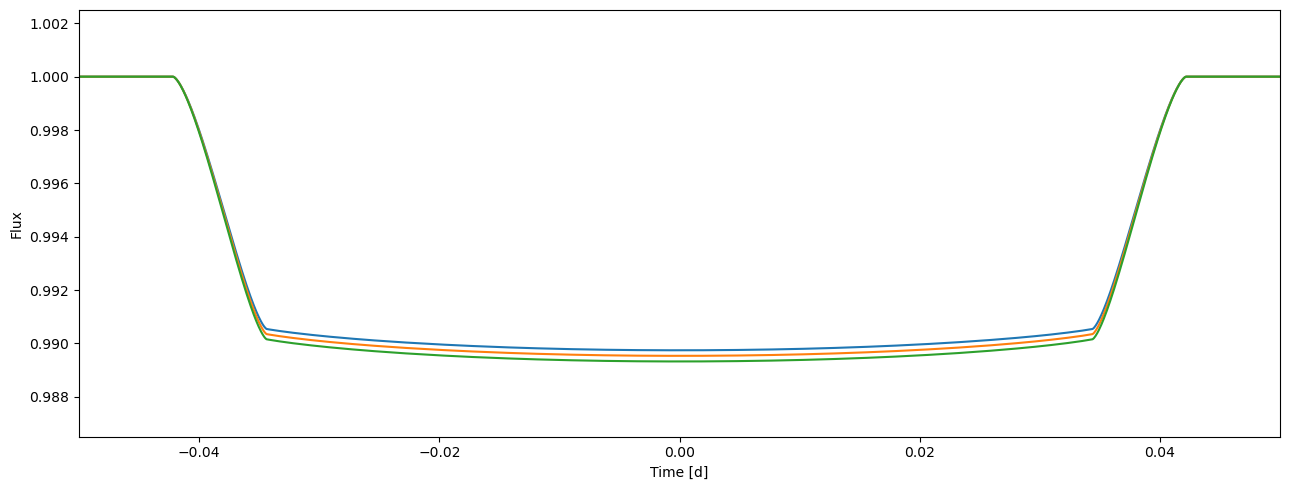

In [8]:
plot_lc(time, flux.T);

### Evaluation for a set of parameters

Like the rest of the *PyTransit* transit models, the transmission spectroscopy model can be evaluated simultaneously for a set of parameters. This is also done by calling `tm.evaluate`, but now

- the planet-star radius ratios (`k`) are given as a 2D array with a shape `(npv, npb)`,
- the limb darkening model parameters (`ldc`) are given as a 3D array with a shape `(npv, npb, nldc)`,
- the orbital parameters `t0`, `p`, `a`, `i`,  `e`,  and `w` are given as 1D arrays (or lists) with a shape `(npv)`.

Now, the ``tm.evaluate`` returns a 3D array with shape `(npv, npb, npt)` with the transit model evaluated for each parameter vector, passband, and mid-transit time given in the ``time`` array

**Note:** Evaluating a parameter set using a single call to `tm.evaluate` is *much faster* than looping over the parameter set in Python, and allows PyTransit to parallelise the model evaluation if `parallel=True` has been set in the model initialiser.

In [50]:
npv = 6
npb = 6
ks    = normal(0.10, 0.006, (npv, npb))
t0s   = normal(0, 0.01, npv)
ps    = normal(1.0, 0.01, npv)
smas  = normal(5.2, 0.1, npv)
incs  = uniform(0.48*pi, 0.5*pi, npv)
es    = uniform(0, 0.25, size=npv)
os    = uniform(0, 2*pi, size=npv)

In [51]:
ldp = tile([0.12, 1.2], (npv, npb, 1))

In [52]:
flux2 = tm.evaluate(ks, ldp, t0s, ps, smas, incs, es, os)

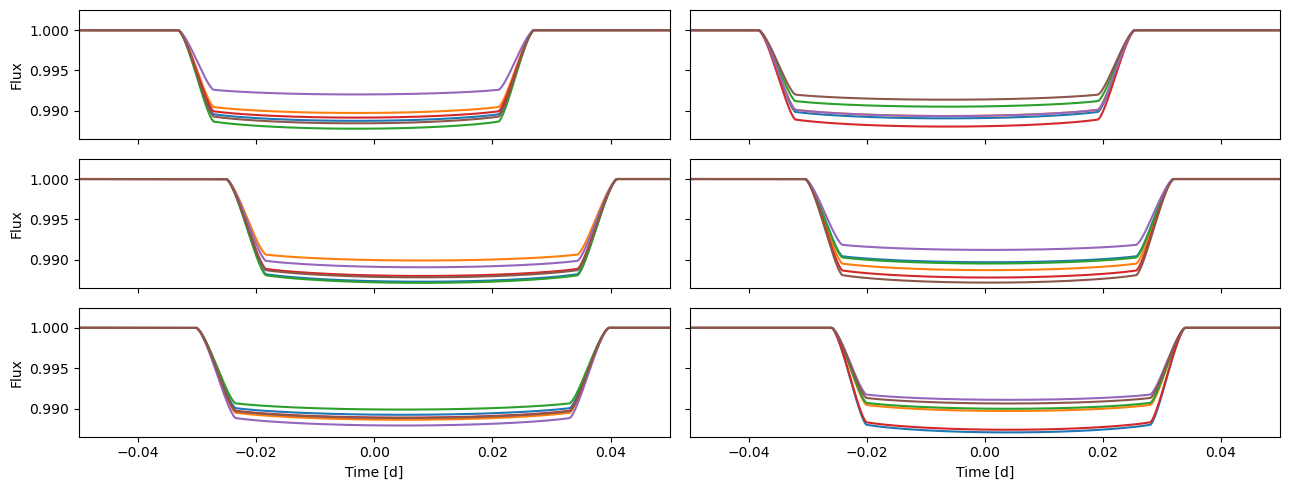

In [53]:
fig, axs = subplots(3, 2, sharex='all', sharey='all')
for iax,ax in enumerate(axs.flat):
    plot_lc(time, flux2[iax].T, ax=ax);
setp(axs[:-1], xlabel='')
setp(axs[:,1], ylabel='')
fig.tight_layout()

### Supersampling

A single photometric observation is always integrated over time. If the exposure time is short compared to the changes in the transit signal shape during the exposure, the observation can be modelled by evaluating the model at the mid-exposure time. However, if the exposure time is long, we need to simluate the integration by calculating the model average over the exposure time (although numerical integration is also a valid approach, it is slightly more demanding computationally and doesn't improve the accuracy significantly). This is achieved by supersampling the model, that is, evaluating the model at several locations inside the exposure and averaging the samples.

Evaluating the model many times for each observation naturally increases the computational burden of the model, but is necessary to model long-cadence observations from the *Kepler* and *TESS* telescopes.

In [55]:
tm = TSModel('power-2')
tm.set_data(time, exptimes=0.02, nsamples=10)

In [61]:
ldc = tile([0.12, 1.2], [3,1])

In [62]:
flux3 = tm.evaluate(k=[0.099, 0.1, 0.101], ldc=ldc, t0=0.0, p=1.0, a=4.2, i=0.5*pi, e=0.0, w=0.0)

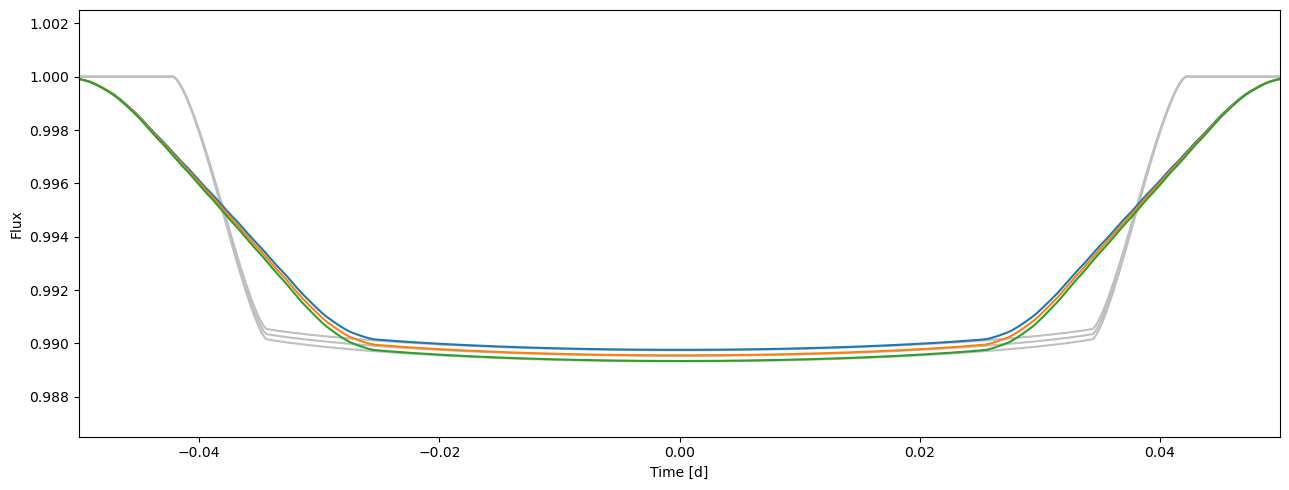

In [63]:
ax = plot_lc(time, flux.T, c='0.75')
plot_lc(time, flux3.T, ax=ax);

---

<center>©2024 Hannu Parviainen</center>